In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers

# Load dataset

In [ ]:
# Access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivazeymaran","key":"df9ac1abf15bab4c557131d24fb653ff"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Jun 18 10:32 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd #Print Working Directory

/content


In [ ]:
!kaggle datasets download -d jehanbhathena/weather-dataset

100% 584M/587M [00:04<00:00, 238MB/s]
100% 587M/587M [00:04<00:00, 140MB/s]


In [ ]:
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset/frost/3937.jpg  

# Split data folder

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

# split with a ratio (train, val, test)
splitfolders.ratio("dataset", output="weather",
                   seed=42, ratio=(.8, .1, .1),
                   group_prefix=None)

Copying files: 6862 files [00:03, 1924.05 files/s]


# Transfer Learning

## Preprocess

In [ ]:
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'weather/train',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'weather/val',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'weather/test',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 5484 images belonging to 11 classes.
Found 682 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


## VGG19

In [ ]:
# Model Initialization
conv_base = VGG19(weights='imagenet',
                  include_top=False,   # Remove the top layers of network
                  input_shape=(150, 150, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers
conv_base.trainable = False

In [ ]:
# Add dense layer for classificatio part
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='softmax'))

# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=val_generator)
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
86/86 [==============================] - 64s 577ms/step - loss: 2.2639 - accuracy: 0.2983 - val_loss: 1.7959 - val_accuracy: 0.4736
Epoch 2/30
86/86 [==============================] - 44s 510ms/step - loss: 1.4588 - accuracy: 0.5197 - val_loss: 1.3223 - val_accuracy: 0.6158
Epoch 3/30
86/86 [==============================] - 49s 546ms/step - loss: 1.2177 - accuracy: 0.5997 - val_loss: 1.0734 - val_accuracy: 0.6642
Epoch 4/30
86/86 [==============================] - 42s 491ms/step - loss: 1.0591 - accuracy: 0.6453 - val_loss: 0.9468 - val_accuracy: 0.6921
Epoch 5/30
86/86 [==============================] - 43s 501ms/step - loss: 0.9708 - accuracy: 0.6707 - val_loss: 0.8493 - val_accuracy: 0.7243
Epoch 6/30
86/86 [==============================] - 42s 487ms/step - loss: 0.9019 - accuracy: 0.6966 - val_loss: 0.8097 - val_accuracy: 0.7390
Epoch 7/30
86/86 [==============================] - 42s 492ms/step - loss: 0.8571 - accuracy: 0.7214 - val_loss: 0.7826 - val_accuracy: 0.7493

### Other way

In [ ]:
def extract_features(generator, sample_count, batch_size):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count, 11))

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i+1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

X_train, y_train = extract_features(train_generator, 5484, batch_size)
X_val, y_val = extract_features(val_generator, 682, batch_size)
X_test, y_test = extract_features(test_generator, 696, batch_size)

# reshape
X_train = np.reshape(X_train, (5484, 4 * 4 * 512))
X_val = np.reshape(X_val, (682, 4 * 4 * 512))
X_test = np.reshape(X_test, (696, 4 * 4 * 512))

# Add dense layer for classificatio part
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='softmax'))

# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))
model.save('model.h5')

## Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

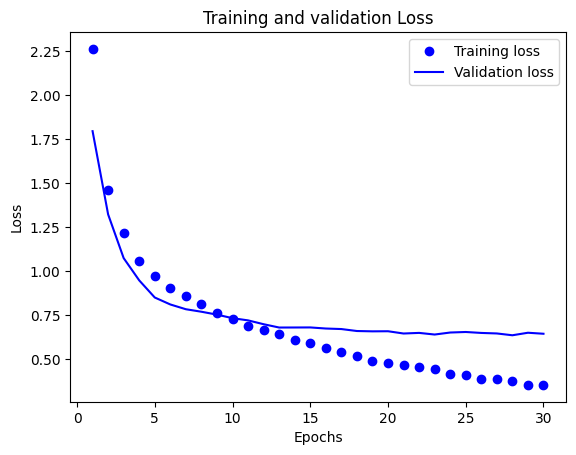

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

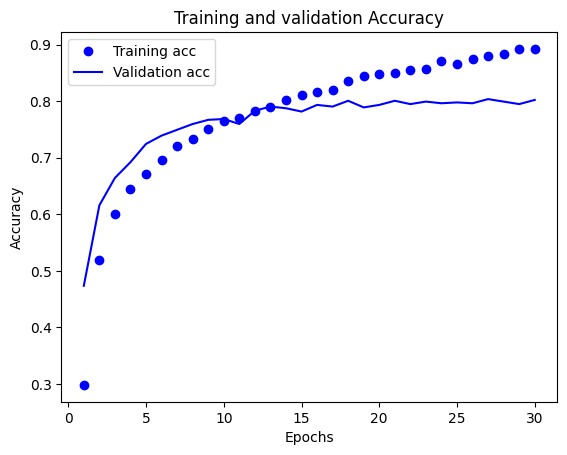

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predict

In [ ]:
_, test_accuracy = model.evaluate(test_generator)
print('Metric of testset (Accuracy):', test_accuracy)

11/11 [==============================] - 10s 808ms/step - loss: 0.6000 - accuracy: 0.8032
Metric of testset (Accuracy): 0.8031609058380127


# Data augmentation

## Preprocess

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'weather/train',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)


Found 5484 images belonging to 11 classes.


## Model

In [ ]:
# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=val_generator)
model.save('model_aug.h5')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
86/86 [==============================] - 71s 808ms/step - loss: 1.0813 - accuracy: 0.6585 - val_loss: 0.6412 - val_accuracy: 0.8065
Epoch 2/30
86/86 [==============================] - 68s 785ms/step - loss: 1.0046 - accuracy: 0.6732 - val_loss: 0.6749 - val_accuracy: 0.7918
Epoch 3/30
86/86 [==============================] - 67s 784ms/step - loss: 0.9976 - accuracy: 0.6721 - val_loss: 0.6421 - val_accuracy: 0.8021
Epoch 4/30
86/86 [==============================] - 67s 782ms/step - loss: 0.9639 - accuracy: 0.6833 - val_loss: 0.6451 - val_accuracy: 0.8079
Epoch 5/30
86/86 [==============================] - 68s 787ms/step - loss: 0.9533 - accuracy: 0.6906 - val_loss: 0.6343 - val_accuracy: 0.8006
Epoch 6/30
86/86 [==============================] - 68s 791ms/step - loss: 0.9476 - accuracy: 0.6909 - val_loss: 0.6336 - val_accuracy: 0.8079
Epoch 7/30
86/86 [==============================] - 69s 801ms/step - loss: 0.9351 - accuracy: 0.6991 - val_loss: 0.6371 - val_accuracy: 0.8152

### Other way

In [ ]:
X_train, y_train = extract_features(train_generator, 5484, batch_size)

# reshape
X_train = np.reshape(X_train, (5484, 4 * 4 * 512))

# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))
model.save('model_aug.h5')

2/2 [==============================] - 13s 3s/step


## Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

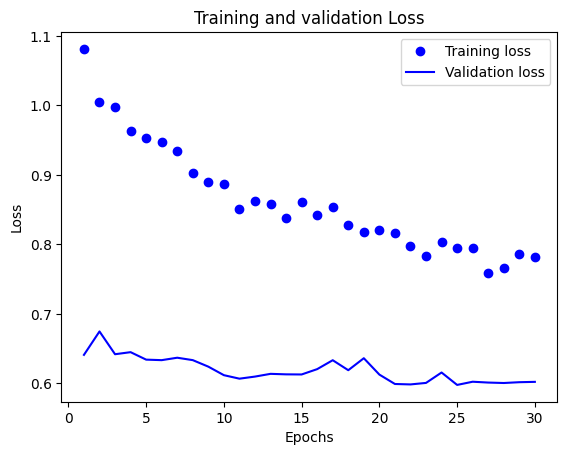

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

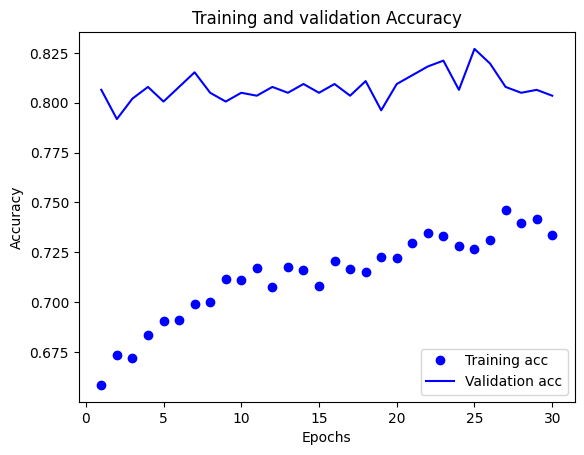

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Predict

In [ ]:
_, test_accuracy = model.evaluate(test_generator)
print('Metric of testset (Accuracy):', test_accuracy)

11/11 [==============================] - 5s 371ms/step - loss: 0.5725 - accuracy: 0.8118
Metric of testset (Accuracy): 0.8117815852165222


# Fine Tuning

## part 1

In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=val_generator)
model.save('model_tune1.h5')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
86/86 [==============================] - 82s 927ms/step - loss: 0.7466 - accuracy: 0.7445 - val_loss: 0.5911 - val_accuracy: 0.8182
Epoch 2/30
86/86 [==============================] - 72s 839ms/step - loss: 0.6751 - accuracy: 0.7684 - val_loss: 0.6434 - val_accuracy: 0.7962
Epoch 3/30
86/86 [==============================] - 71s 820ms/step - loss: 0.6443 - accuracy: 0.7764 - val_loss: 0.6399 - val_accuracy: 0.8035
Epoch 4/30
86/86 [==============================] - 68s 796ms/step - loss: 0.5970 - accuracy: 0.8014 - val_loss: 0.5128 - val_accuracy: 0.8255
Epoch 5/30
86/86 [==============================] - 68s 794ms/step - loss: 0.5630 - accuracy: 0.8076 - val_loss: 0.5101 - val_accuracy: 0.8387
Epoch 6/30
86/86 [==============================] - 68s 794ms/step - loss: 0.5513 - accuracy: 0.8125 - val_loss: 0.4829 - val_accuracy: 0.8387
Epoch 7/30
86/86 [==============================] - 68s 794ms/step - loss: 0.5192 - accuracy: 0.8240 - val_loss: 0.5343 - val_accuracy: 0.8358

### Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

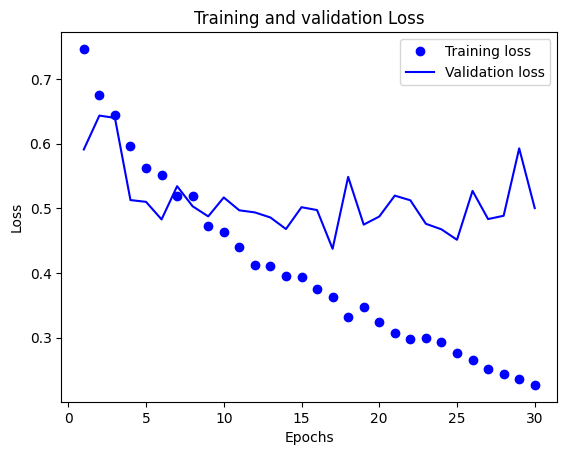

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

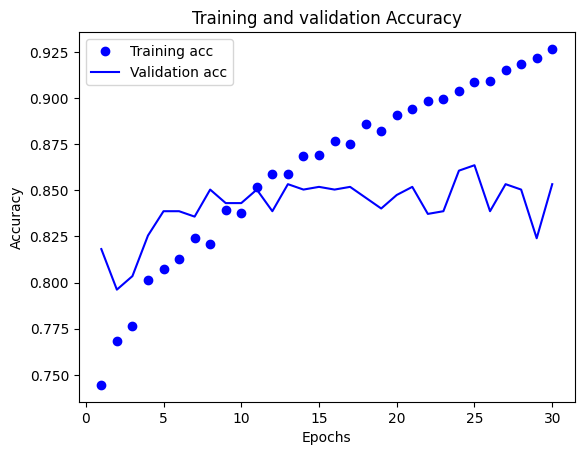

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predict

In [ ]:
_, test_accuracy = model.evaluate(test_generator)
print('Metric of testset (Accuracy):', test_accuracy)

11/11 [==============================] - 5s 465ms/step - loss: 0.4401 - accuracy: 0.8736
Metric of testset (Accuracy): 0.8735632300376892


## part 2

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# Compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=val_generator)
model.save('model_tune2.h5')

Epoch 1/30
86/86 [==============================] - 75s 851ms/step - loss: 0.3315 - accuracy: 0.8866 - val_loss: 0.5359 - val_accuracy: 0.8578
Epoch 2/30
86/86 [==============================] - 73s 851ms/step - loss: 0.2928 - accuracy: 0.8962 - val_loss: 0.6028 - val_accuracy: 0.8358
Epoch 3/30
86/86 [==============================] - 74s 863ms/step - loss: 0.2543 - accuracy: 0.9141 - val_loss: 0.5790 - val_accuracy: 0.8431
Epoch 4/30
86/86 [==============================] - 77s 895ms/step - loss: 0.2594 - accuracy: 0.9127 - val_loss: 0.7713 - val_accuracy: 0.8240
Epoch 5/30
86/86 [==============================] - 74s 863ms/step - loss: 0.2519 - accuracy: 0.9132 - val_loss: 0.5849 - val_accuracy: 0.8358
Epoch 6/30
86/86 [==============================] - 73s 844ms/step - loss: 0.2341 - accuracy: 0.9203 - val_loss: 0.5112 - val_accuracy: 0.8636
Epoch 7/30
86/86 [==============================] - 72s 837ms/step - loss: 0.2314 - accuracy: 0.9251 - val_loss: 0.5352 - val_accuracy: 0.8651

### Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

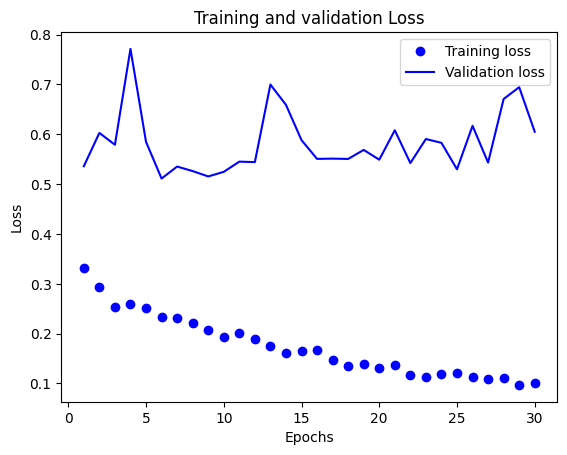

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

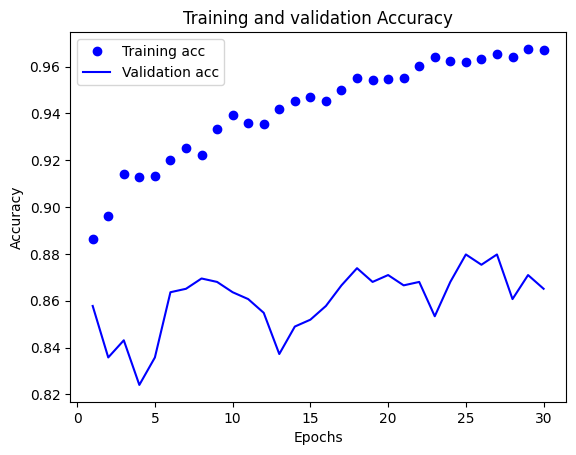

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predict

In [ ]:
_, test_accuracy = model.evaluate(test_generator)
print('Metric of testset (Accuracy):', test_accuracy)

11/11 [==============================] - 4s 384ms/step - loss: 0.5069 - accuracy: 0.8894
Metric of testset (Accuracy): 0.8893678188323975
